<a href="https://colab.research.google.com/github/LSegota/LSegota/blob/main/Alzheimer's.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <span style='color:aliceblue'><center style='background:#002E94;border-radius:0px 25px;padding:25px'> Alzheimer Classification with MRI Images </center></span>

About the dataset:

The Data is hand collected from various websites with each and every labels verified.

The data consists of MRI images. The data has four classes of images both in training as well as a testing set:

Mild Demented

Moderate Demented

Non Demented

Very Mild Demented

In [ ]:
#Environments
import os
import warnings
warnings.filterwarnings("ignore")

In [ ]:
#Imports
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras import optimizers, losses
import seaborn as sns
import matplotlib.pyplot as plt

# System libraries
from pathlib import Path
import os.path
# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [ ]:
# Mounting Google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# unpackaging
!unrar x "/content/drive/MyDrive/AugmentedAlzheimerDataset.rar" "/content/drive/MyDrive/Dataset"

Streaming output truncated to the last 5000 lines.
Extracting  /content/drive/MyDrive/Dataset/AugmentedAlzheimerDataset/VeryMildDemented/705f871d-d4dd-4ccb-a713-d20724fe2f17.jpg      85%  OK 
Extracting  /content/drive/MyDrive/Dataset/AugmentedAlzheimerDataset/VeryMildDemented/7069c7cf-f4db-4c97-9c80-db7f3abd0643.jpg      85%  OK 
Extracting  /content/drive/MyDrive/Dataset/AugmentedAlzheimerDataset/VeryMildDemented/70743509-c035-4392-b5a5-a35687c4ae67.jpg      85%  OK 
Extracting  /content/drive/MyDrive/Dataset/AugmentedAlzheimerDataset/VeryMildDemented/707c8044-826c-410c-abf7-0355d770e966.jpg      85%  OK 
Extracting  /content/drive/MyDrive/Dataset/AugmentedAlzheimerDataset/VeryMildDemented/707d3e15-7d33-44e2-8172-906ccff06a36.jpg      85%  OK 
Extracting  /content/drive/MyDrive/Dataset/AugmentedAlzheimerDataset/VeryMildDemented/70804c51-b847-49e4-9cb0-73800c71b079.jpg      85%  OK 
Extracting  /content/drive/MyDrive/Dataset/Augmen

Getting data

In [ ]:
data = "/content/drive/MyDrive/Dataset/AugmentedAlzheimerDataset"

In [ ]:
image_dir = Path(data)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

In [ ]:
import PIL
from pathlib import Path
from PIL import UnidentifiedImageError

path = Path("/content/AugmentedAlzheimerDataset.rar").rglob("*.jpg")
for img_p in path:
    try:
        img = PIL.Image.open(img_p)
    except PIL.UnidentifiedImageError:
            print(img_p)

In [ ]:
image_df

,Filepath,Label
0,/content/drive/MyDrive/Dataset/AugmentedAlzhei...,MildDemented
1,/content/drive/MyDrive/Dataset/AugmentedAlzhei...,MildDemented
2,/content/drive/MyDrive/Dataset/AugmentedAlzhei...,MildDemented
3,/content/drive/MyDrive/Dataset/AugmentedAlzhei...,MildDemented
4,/content/drive/MyDrive/Dataset/AugmentedAlzhei...,MildDemented
...,...,...
33979,/content/drive/MyDrive/Dataset/AugmentedAlzhei...,VeryMildDemented
33980,/content/drive/MyDrive/Dataset/AugmentedAlzhei...,VeryMildDemented
33981,/content/drive/MyDrive/Dataset/AugmentedAlzhei...,VeryMildDemented
33982,/content/drive/MyDrive/Dataset/AugmentedAlzhei...,VeryMildDemented


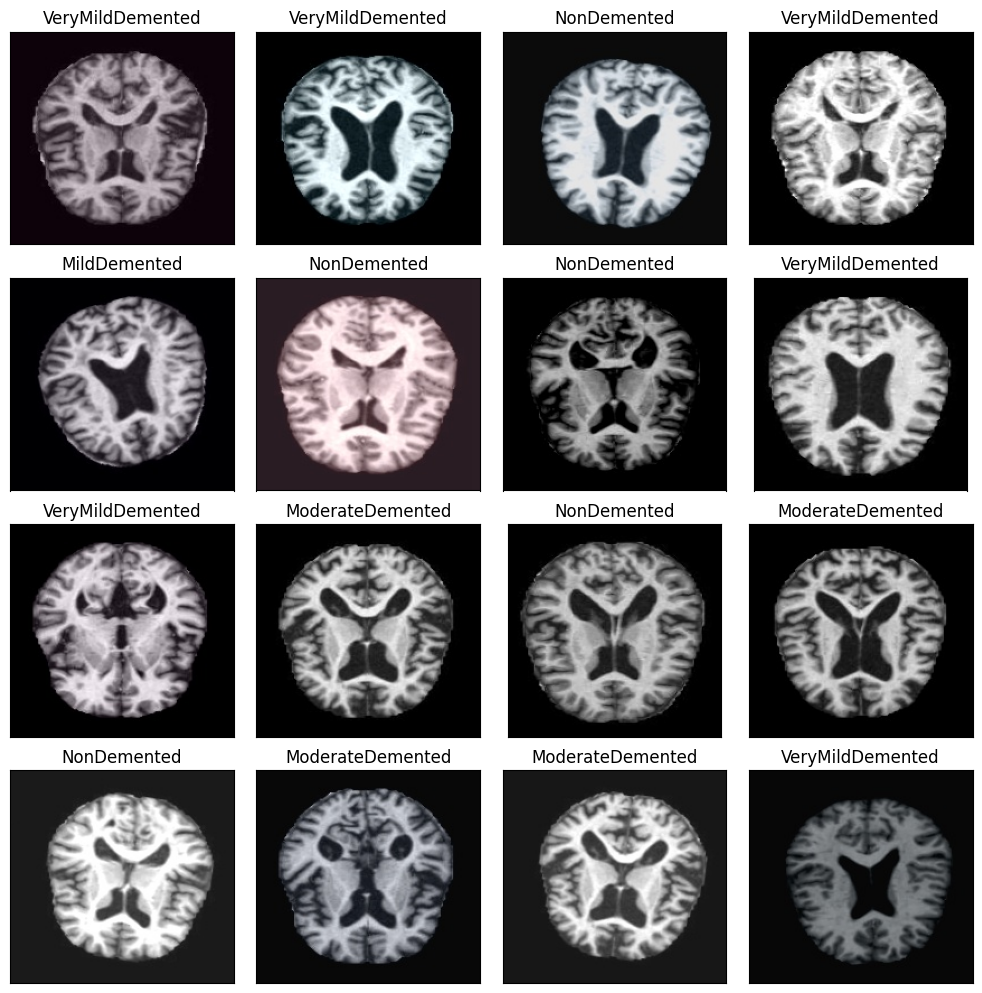

In [ ]:
# Display random 16 pictures of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
    validation_split=0.2) # setting the validation split

In [ ]:
train_images = train_datagen.flow_from_directory(
    data,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training') # set as training data

validation_images = train_datagen.flow_from_directory(
    data , # same directory as training data
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation') # set as validation data



Found 27188 images belonging to 4 classes.
Found 6796 images belonging to 4 classes.


CNN Model

In [ ]:
model = tf.keras.models.Sequential([
    Conv2D(16, (3,3), activation = 'relu', input_shape = (224,224, 3)),
    MaxPooling2D(2,2),
    Conv2D(32, (3,3), activation = 'relu'),
    MaxPooling2D(2,2),
    Conv2D(32, (3,3), activation = 'relu'),
    MaxPooling2D(2,2),
    Conv2D(32, (3,3), activation = 'relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(512, activation = 'relu'),
    Dropout(0.2),
    Dense(4, activation = 'softmax')
])



In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(), metrics = ['accuracy'],)
history = model.fit(train_images,
    steps_per_epoch=len(train_images),
    validation_data=validation_images,
    validation_steps=len(validation_images),
    epochs=10)

Epoch 1/10
850/850 [==============================] - 190s 214ms/step - loss: 0.8630 - accuracy: 0.5981 - val_loss: 0.6201 - val_accuracy: 0.7269
Epoch 2/10
850/850 [==============================] - 163s 191ms/step - loss: 0.5047 - accuracy: 0.7784 - val_loss: 0.4091 - val_accuracy: 0.8311
Epoch 3/10
850/850 [==============================] - 177s 208ms/step - loss: 0.3222 - accuracy: 0.8665 - val_loss: 0.3510 - val_accuracy: 0.8582
Epoch 4/10
850/850 [==============================] - 179s 211ms/step - loss: 0.2207 - accuracy: 0.9112 - val_loss: 0.2639 - val_accuracy: 0.9002
Epoch 5/10
850/850 [==============================] - 171s 201ms/step - loss: 0.1577 - accuracy: 0.9398 - val_loss: 0.2414 - val_accuracy: 0.9089
Epoch 6/10
850/850 [==============================] - 163s 191ms/step - loss: 0.1202 - accuracy: 0.9531 - val_loss: 0.2681 - val_accuracy: 0.9102
Epoch 7/10
850/850 [==============================] - 173s 204ms/step - loss: 0.0937 - accuracy: 0.9652 - val_loss: 0.2950 -

***Model is overfitting***

We can see how the accuracy of the training data has begun to overtake the accuracy of the validation data, keeping in mind this is a relatively large dataset, and the fact that our dataset has varying amounts of samples across the different classes, we can try to avoid this using different methods, some of them are: using class weights, increasing droput or mplementing a learning rate schedule to adapt the learning rate during training.

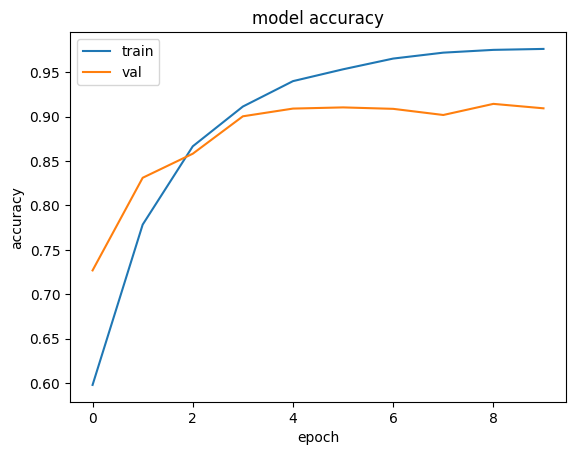

In [ ]:
#Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

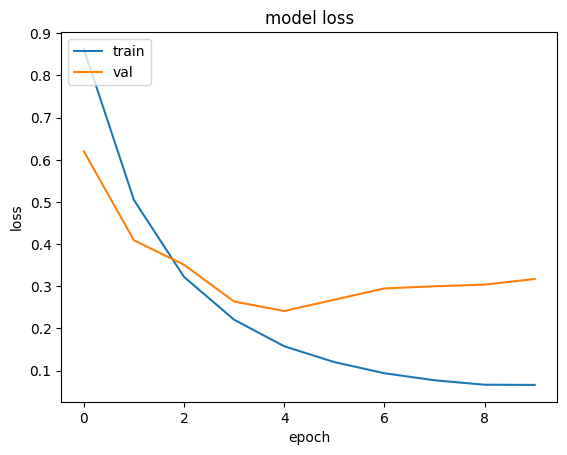

In [ ]:
# loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

**Trying transfer learning using an inception model**

In [ ]:
inception_model = Sequential()

pretrained_model= tf.keras.applications.InceptionV3(include_top=False,
                   input_shape=(224,224,3),
                   pooling='avg',classes=4,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

inception_model.add(pretrained_model)

87910968/87910968 [==============================] - 1s 0us/step


In [ ]:
inception_model.add(Flatten())
inception_model.add(Dense(512, activation='relu'))
inception_model.add(Dropout(0.2))
inception_model.add(Dense(4, activation='softmax'))

In [ ]:
inception_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               1049088   
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 22853924 (87.18 MB)
Trainable params: 1051140 (4.01 MB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________


In [ ]:
inception_model.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(), metrics = ['accuracy'])

history = inception_model.fit(train_images,
    steps_per_epoch=len(train_images),
    validation_data=validation_images,
    validation_steps=len(validation_images),
    epochs=10)

Epoch 1/10
850/850 [==============================] - 187s 213ms/step - loss: 0.9253 - accuracy: 0.5745 - val_loss: 0.7697 - val_accuracy: 0.6548
Epoch 2/10
850/850 [==============================] - 180s 212ms/step - loss: 0.7775 - accuracy: 0.6432 - val_loss: 0.7285 - val_accuracy: 0.6733
Epoch 3/10
850/850 [==============================] - 181s 212ms/step - loss: 0.7287 - accuracy: 0.6675 - val_loss: 0.6754 - val_accuracy: 0.6875
Epoch 4/10
850/850 [==============================] - 176s 207ms/step - loss: 0.6894 - accuracy: 0.6876 - val_loss: 0.6822 - val_accuracy: 0.6903
Epoch 5/10
850/850 [==============================] - 183s 215ms/step - loss: 0.6556 - accuracy: 0.7033 - val_loss: 0.6230 - val_accuracy: 0.7181
Epoch 6/10
850/850 [==============================] - 176s 207ms/step - loss: 0.6352 - accuracy: 0.7133 - val_loss: 0.6025 - val_accuracy: 0.7318
Epoch 7/10
850/850 [==============================] - 167s 196ms/step - loss: 0.6035 - accuracy: 0.7253 - val_loss: 0.6150 -

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


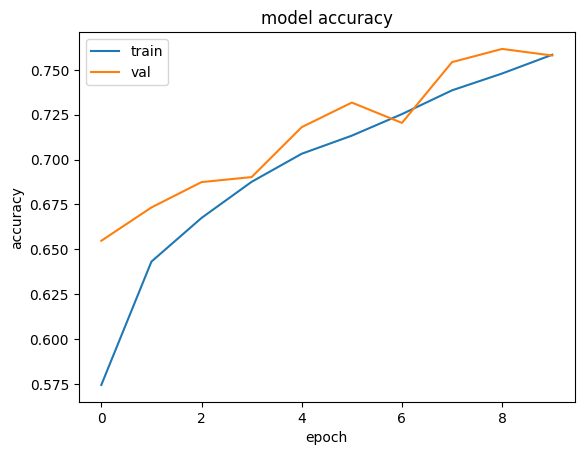

In [ ]:
#Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

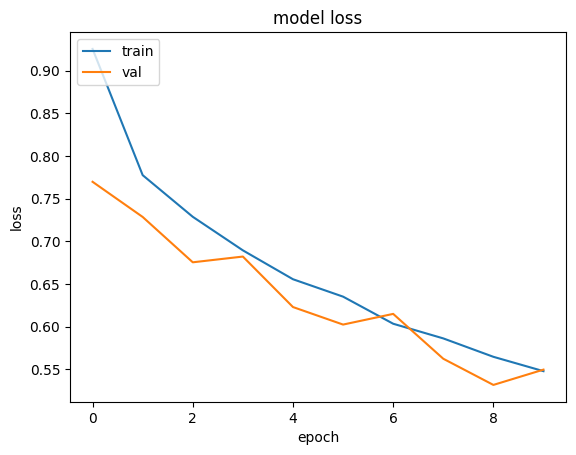

In [ ]:
# loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# **<span style="color:#DA291C;">Conclusion</span>**

> We can see how these different learning models predict different behaviour based on the nature of the learning models and the chosen parameters

